In [94]:
# import modules
# add path
import sys, os
sys.path.append(os.path.abspath("/Users/karl/Documents/Git/A2C_test"))
# modules used in training
import copy
import glob
import os
import time
from collections import deque
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import algo
from arguments import get_args
from envs import make_vec_envs
from model import Policy
from storage import RolloutStorage
from utils import get_vec_normalize, update_mode, neuro_activity, obs_representation
from tensorboardX import SummaryWriter
from distributions import Categorical, DiagGaussian
from utils import init, init_normc_, tanh_g
FixedCategorical = torch.distributions.Categorical
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

In [115]:
# args
class Args:
    def __init__(self):
        self.env_name = "MsPacmanNoFrameskip-v0"
        self.seed = 1
        self.num_processes = 1
        self.gamma = 0.99
        self.log_dir = '.'
        self.add_timestep = False
        self.carl_wrapper = True
        self.activation = 1
        self.modulation = 0
        self.sync = False
        self.recurrent_policy = False
        #self.saved_model = "/Users/karl/Documents/Git/A2C_test/NewResult/f1_modulation/tanh_f1modulation_fixed0.1_1.0/Jan12_07-47-05_jinwei-a2c-10/MsPacmanNoFrameskip-v0.pt"
        self.saved_model = "/Users/karl/Documents/Git/A2C_test/NewResult/no_modulation/tanh_nomodulation_norm_1.1/Jan11_19-56-27_jinwei-a2c-1/MsPacmanNoFrameskip-v0.pt"

In [116]:
# initialize
# load model and prepare environment
args = Args()
device = 'cpu'
envs = make_vec_envs(args.env_name, args.seed, args.num_processes,
                        args.gamma, args.log_dir, args.add_timestep, device, True, 4, args.carl_wrapper)
actor_critic = torch.load(args.saved_model)

In [180]:
# simulation function
def simulate(envs, ac, gs, mute=False, action_g=1.0):
    # store result
    entropies = {}
    actions = {}
    features = {}
    rewards = []
    images = []
    steps = []
    for i in range(len(gs)):
        actions[i] = []
        entropies[i] = []
    diff_obs = [] # obs when actions are different
    diff_steps = [] # timestep when actions are different
    done_steps = []  # timestep when it's done (3 lives)
    pd_errors = []
    evaluations = [] 
    observations = []
        
    # prepare environment
    obs = envs.reset()/255
    g = torch.ones(1,1)
    rnn_hxs = torch.zeros(1,1)
    masks = torch.zeros(1,1)
    step = 0
    done = [0]
    # play the game
    while(True):
        step += 1
        if not mute:
            if step % 100 == 0:
                print("has run ", step, " steps")
        actual_action = None
        observations.append(obs*255)
        for i in range(len(gs)):
            value, actor_features, rnn_hxs, x = ac.base(obs, g*gs[i], rnn_hxs, masks)
            dist = ac.dist(actor_features)
            action = dist.mode()
            entropy = dist.entropy().item()
            actions[i].append(action.item())
            entropies[i].append(entropy)
            # there must be a g of 1 in gs
            if gs[i] == action_g:
                actual_action = action
                pre_value = value
        if not (actions[0][-1] == actions[1][-1] and actions[0][-1] == actions[2][-1]):
            diff_obs.append(obs)
            diff_steps.append(step-1) # step start from 1
        obs, reward, done, infos = envs.step(actual_action)
        obs = obs/255
        if done[0]:
            done_steps.append(step-1)
        next_value, _, _, _ = ac.base(obs, g, rnn_hxs, masks)
        pd_errors.append(next_value.item() + reward.item() - pre_value.item())
        rewards.append(reward)
        if 'episode' in infos[0].keys():
            print("Score: ", infos[0]['episode'])
            break
    return actions, entropies, rewards, diff_obs, diff_steps, done_steps, pd_errors, observations
        
# Average entropies for multiple times
def get_entropy(envs, ac, gs, t):
    avg_entropies = []
    for i in range(len(gs)):
        avg_entropies.append(list())
    for i in range(t):
        print(i)
        _,entropies, _,_,_,_ = simulate(envs, ac, gs, mute=True)
        for j in range(len(gs)):
            avg_entropies[j].append(sum(entropies[j])/len(entropies[j]))
    return avg_entropies


# Test whether actor features change
def check_features(envs, ac):

    # prepare environment
    obs = envs.reset()/255
    g = torch.ones(1,1)
    rnn_hxs = torch.zeros(1,1)
    masks = torch.zeros(1,1)
    step = 0
    done = [0]
    
    # play the game
    while(True):
        step += 1
        if step % 100 == 0:
            print("has run ", step, " steps")
        _, actor_features1, _, _ = ac.base(obs, g*1, rnn_hxs, masks)
        _, actor_features2, _, _ = ac.base(obs, g*0.5, rnn_hxs, masks)
        _, actor_features3, _, _ = ac.base(obs, g*2, rnn_hxs, masks)
        same_count = torch.sum(torch.eq(actor_features1,actor_features2) + torch.eq(actor_features2,actor_features3)).item()
        if same_count != 1024:
            print('Different!')
        dist = ac.dist(actor_features1)
        action = dist.sample()
        obs, reward, done, infos = envs.step(action)
        if 'episode' in infos[0].keys():
            print("Score: ", infos[0]['episode'])
            break
        obs = obs/255
    return 
        


In [182]:
gs = [1.0, 0.5, 2.0]
actions, entropies, rewards, diff_obs, diff_steps, done_steps, pd_errors, observations = simulate(envs, actor_critic, gs)

has run  100  steps
has run  200  steps
has run  300  steps
has run  400  steps
has run  500  steps
has run  600  steps
has run  700  steps
has run  800  steps
has run  900  steps
has run  1000  steps
Score:  {'r': 4620.0, 'l': 1058, 't': 117163.867608}


In [184]:
len(pd_errors)

1056

In [131]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [176]:
newentropy = smooth(entropies[0],0.1)

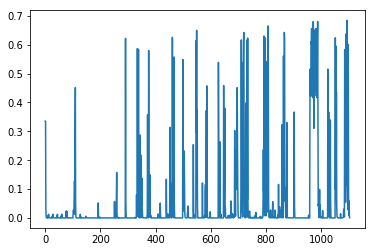

In [177]:
plt.plot(range(len(newentropy)), newentropy)
#for done_step in done_steps:
    

In [169]:
abs_pd_errors = [abs(i) for i in pd_errors]

In [170]:
newabspderrors = smooth(abs_pd_errors,0.75)

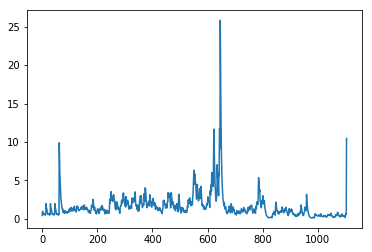

In [171]:
plt.plot(range(len(newabspderrors)), newabspderrors)


In [162]:
newpderrors = smooth(pd_errors,0.75)

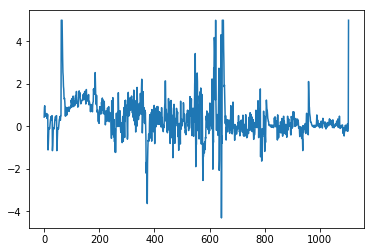

In [179]:
plt.plot(range(len(newpderrors)), newpderrors)


In [178]:
newpderrors = [min(i,5) for i in newpderrors]

In [153]:
done_steps

[807, 960]

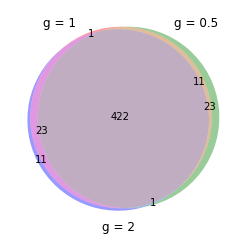

In [104]:
# Analyze
# actions
action_analysis = []
action_analysis.append(actions[0].copy())
action_analysis.append(actions[1].copy())
action_analysis.append(actions[2].copy())
for l in action_analysis:
    for i in range(len(l)):
        l[i] = str(i)+"-"+str(l[i])
# show via venn diagram
venn3([set(action_analysis[0]), set(action_analysis[1]), set(action_analysis[2])], set_labels = ('g = 1', 'g = 0.5', 'g = 2'))
plt.show()

In [117]:
# Analyze 
# entropy
gs = [1.0, 0.5, 2.0]
for i in range(5):
    avg_entropies = get_entropy(envs, actor_critic, gs, 1)
    print(avg_entropies)

0
Score:  {'r': 7320.0, 'l': 1161, 't': 29.046417}
[[0.03949318135306399], [0.03949318135306399], [0.03949318135306399]]
0
Score:  {'r': 6400.0, 'l': 1367, 't': 63.127889}
[[0.03805927533892601], [0.03805927533892601], [0.03805927533892601]]
0
Score:  {'r': 6550.0, 'l': 1322, 't': 92.102747}
[[0.056356739306528014], [0.056356739306528014], [0.056356739306528014]]
0
Score:  {'r': 4990.0, 'l': 976, 't': 117.986073}
[[0.05564967286029266], [0.05564967286029266], [0.05564967286029266]]
0
Score:  {'r': 6450.0, 'l': 1064, 't': 138.972983}
[[0.045058620613577335], [0.045058620613577335], [0.045058620613577335]]
